# 0D - Supplementary videos for Carbon Panel Plots

Videos capturing the evolution of carbon area densities, sediment thicknesses, subduction slab dip, and spreading rates - all outputs of `Notebook 01-Sources-of-Carbon.ipynb`.

A dependency for the colormaps is the package `cmcrameri`.

In [1]:
import numpy as np
import gplately.pygplates as pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.gridspec as gridspec
from slabdip import SlabDipper
import matplotlib
import pandas as pd

from cmcrameri import cm
import moviepy.editor as mpy

In [2]:
from joblib import Parallel, delayed
import joblib

In [3]:
# Use GPlately's DataServer to get a rotation model, topology features and static polygons
gdownload = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()

max_time = 1000
time = max_time
gplot = gplately.PlotTopologies(model, time=time, coastlines=coastlines, continents=continents)


reconstruction_times = np.arange(max_time, -1, -1)

In [4]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Apr21"

# Don't change this: directory to input files
output_directory = "../Outputs/{}/Videos/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)

grid_directory = "../Muller2022_InputGrids/"

def defineGridFiles():
    
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"
    
    return agegrid_filename, spreadrate_filename

### A function to plot all plate polygon boundaries

In [5]:
def latlonticks(ax):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False,
              linewidth=1, color='gray', alpha=0.3,)

    ax.text(0.49,-0.03, '60°E', transform=ax.transAxes)
    ax.text(0.46,-0.03, '0°', transform=ax.transAxes)
    ax.text(0.40,-0.025, '60°W', transform=ax.transAxes)
    
    gl.top_labels=False
    gl.bottom_labels=False
    return

## Plots of sedimentary carbon storage 
for 150, 100, 50 and 0 Ma (2 x 2 map panel) ) (use colormap lipori)

In [6]:
def plot_sed_carbon(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(

        "../Outputs/{}/Notebook01/Reservoirs/Sediment/mean/carbon_sediment_grid_{:04d}.nc".format(folder_name, time)
    ).data

    #cmap = cm.batlow
    #cmap.set_bad('lightgrey',1.)

    lognorm_cmap = cm.batlow
    # Manually fill all empty regions in the 1st plot with a black background
    ax.imshow(np.array([[0,0],[0,0]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
      transform=ccrs.PlateCarree(), zorder=0)

    lognorm_cmap.set_bad((1,1,1), alpha=0)

    # times by 1e6 to go from Mt to t
    im = ax.imshow(
        grd*1e6, origin='lower', cmap=lognorm_cmap,
        norm=mcolors.LogNorm(vmin=1e0, vmax=1e2),
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, facecolor='w')
    gplot.plot_coastlines(ax, facecolor='lightgrey', alpha=0.46)
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)
    
    latlonticks(ax)

    plt.subplots_adjust(wspace=0.02)
    cb_ax = fig.add_axes([0.4, 0.02, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, pad=0.1, extend='max')
    cb.set_label(label='Carbon area density (T/m^$2$)')

    if save_fig:
        os.makedirs(output_directory+"carb_sed", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"carb_sed/sediment_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
        
    plt.close()
    return

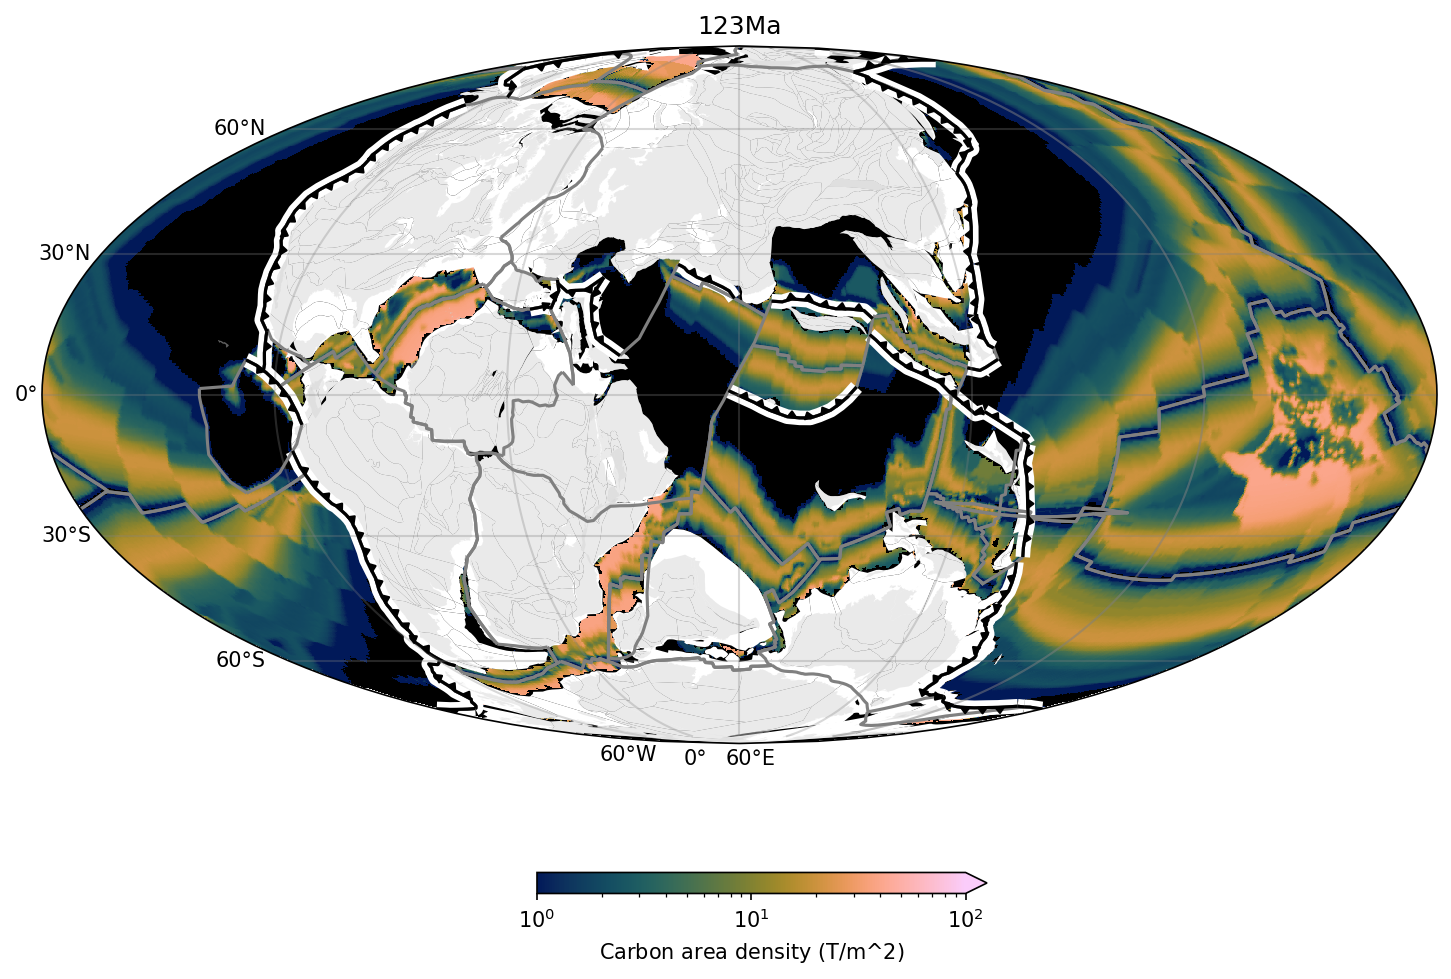

In [7]:
plot_sed_carbon(time=123)

In [8]:
carbsed_time = np.arange(170,-1,-1)
# Use LokyBackend to protect the netCDF routine
carbsed = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sed_carbon) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in carbsed_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  9.3min finished


In [9]:
import moviepy.editor as mpy

frame_list = []
for time in carbsed_time:
    frame_list.append(
        output_directory+"/carb_sed/sediment_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(output_directory+"/sediment_carbon_mean_area_density.mp4", fps=24)


Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//sediment_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//sediment_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//sediment_carbon_mean_area_density.mp4


## Plots of serpentinite carbon storage 

at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap navia)

In [10]:
def plot_serpentinite(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(
        "../Outputs/{}/Notebook01/Reservoirs/Serpentinite/mean/carbon_serpentinite_grid_{:04d}.nc".format(folder_name, time)
    ).data

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.imola, 
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmax=3,
        vmin=0
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='lightgrey', )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, color='k', label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)
     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/serpentinite", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/serpentinite/serpentinite_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
    plt.close()
    return

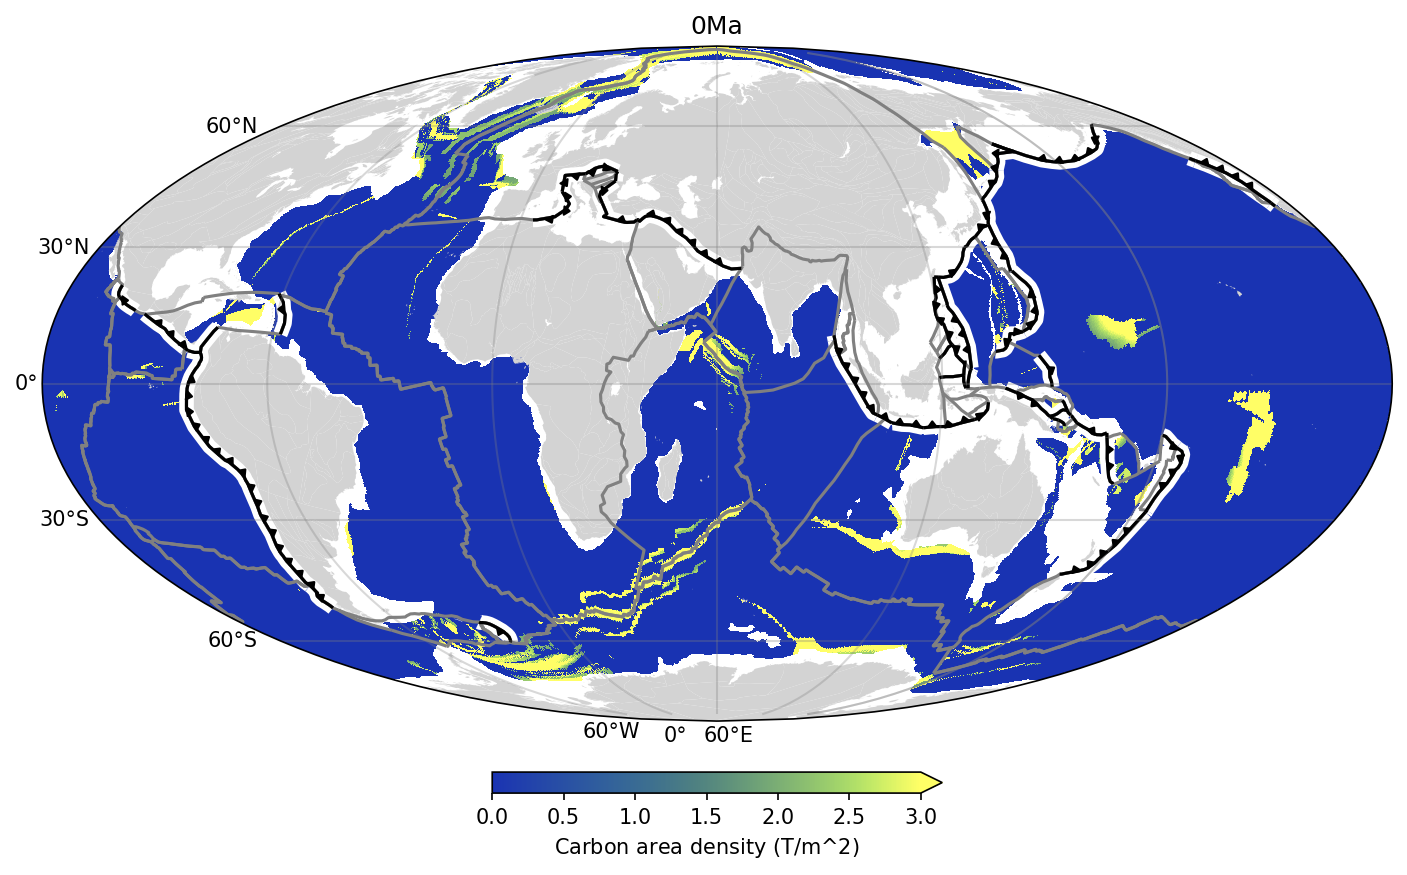

In [11]:
plot_serpentinite(time=0)

In [12]:
# Use LokyBackend to protect the netCDF routine
serpentinite = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_serpentinite) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 39.9min finished


In [13]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/serpentinite/serpentinite_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(output_directory+"/serpentinite_carbon_mean_area_density.mp4", fps=24)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//serpentinite_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//serpentinite_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//serpentinite_carbon_mean_area_density.mp4


## Crustal carbon storage 
at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap batlow)


In [14]:
def plot_crustal(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr


    grd = gplately.Raster(

        "../Outputs/{}/Notebook01/Reservoirs/Crust/mean/carbon_crust_grid_{:04d}.nc".format(folder_name, time)
    ).data

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.batlow,
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmin=3,
        vmax=10
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='lightgrey',  )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/crust", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/crust/crust_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
        
    plt.close()
    return
    

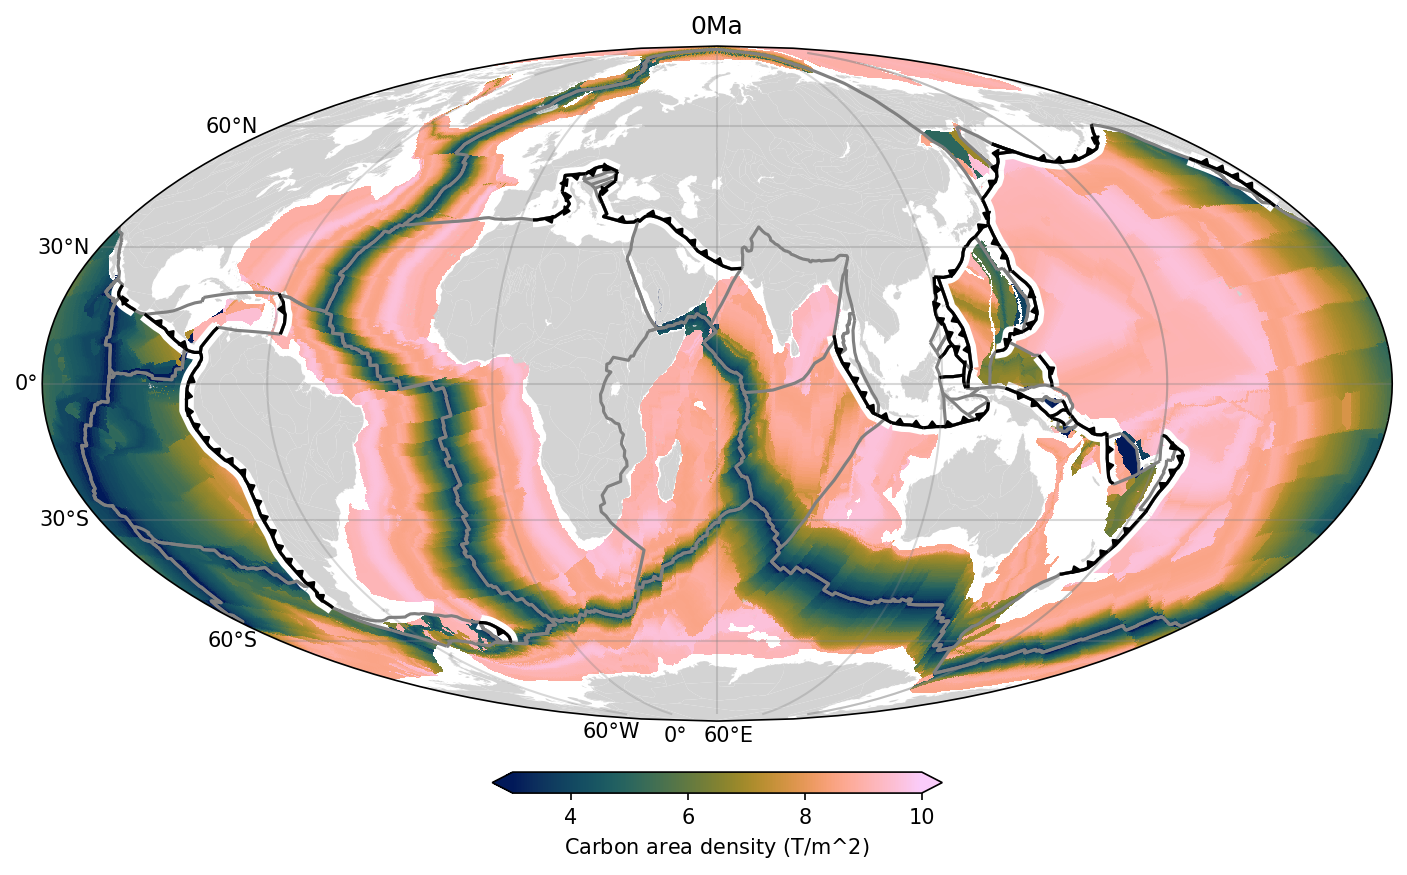

In [15]:
plot_crustal(time=0)

In [16]:
# Use LokyBackend to protect the netCDF routine
crustal = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_crustal) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 38.8min finished


In [17]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/crust/crust_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/crust_carbon_mean_area_density.mp4",
    fps=24
)


Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//crust_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//crust_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//crust_carbon_mean_area_density.mp4


## Lithospheric carbon storage 
at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap lapaz)


In [18]:
def plot_lithosphere(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(
        "../Outputs/{}/Notebook01/Reservoirs/Lithosphere/mean/carbon_lithosphere_grid_{:04d}.nc".format(folder_name, time)
    ).data

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.lapaz, 
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmin=3.6, vmax = 4.6
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='lightgrey', alpha=0.46, )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, zorder=2)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/lithosphere", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/lithosphere/lithosphere_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()

    plt.close()
    return

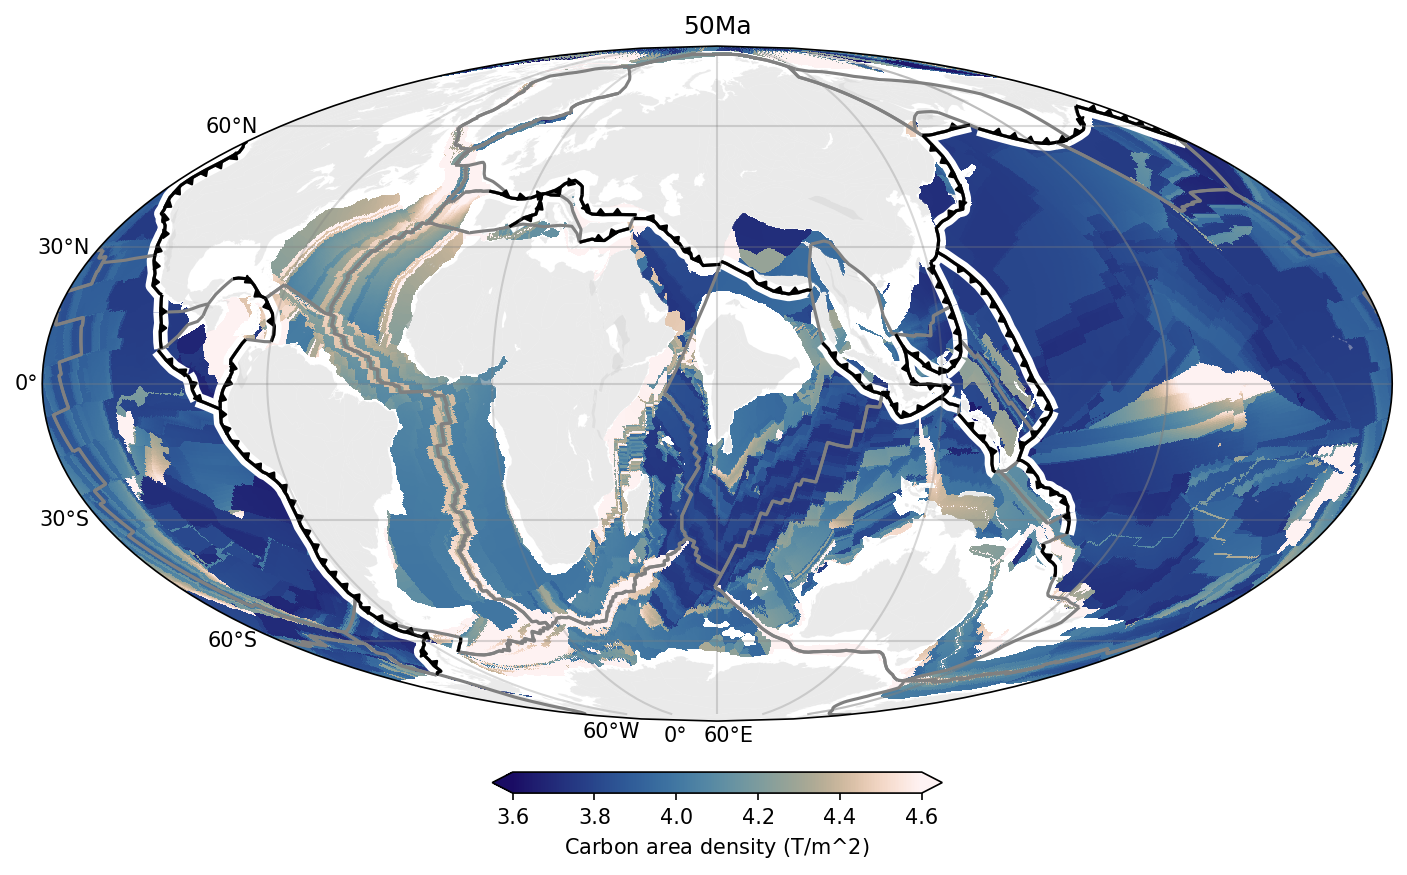

In [19]:
plot_lithosphere(time=50)

In [20]:
# Use LokyBackend to protect the netCDF routine
lithosphere = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_lithosphere) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 39.0min finished


In [21]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/lithosphere/lithosphere_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/lithosphere_carbon_mean_area_density.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//lithosphere_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//lithosphere_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//lithosphere_carbon_mean_area_density.mp4


## Plots of slab dip (degrees)

In [22]:
from cmaptools import readcpt, joincmap, DynamicColormap
cptfile = "../utils/age_1000-0.cpt"
custom_cmap = readcpt(cptfile)

def plot_slabdip(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7))

    time_window = 10 #Myr

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]

    age_grid, _ = defineGridFiles()

    agegrid = gplately.Raster(age_grid.format(time))

    im = ax.imshow(agegrid.data, extent=extent_globe, cmap=custom_cmap, origin='lower', alpha=0.2,

               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
    )
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none')


    subduction_filename = "../H2O_review_paper/H2O_Review_Bundle/{}/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(folder_name, int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_slabdip = df_time["slab_dip"].to_numpy()

    #vmin, vmax = colour_range["Sediment"]
    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=curr_subd_slabdip, cmap=cm.lipari_r, vmin=20, vmax=50,

        transform=ccrs.PlateCarree(), rasterized=True,
    )
    
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9)
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax1 = fig.add_axes([0.1, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')

    cax2 = fig.add_axes([0.5, 0.21, 0.25, 0.02])
    fig.colorbar(sc, cax=cax2, orientation='horizontal', label='Slab dip (°)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/slab_dip", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/slab_dip/slab_dip_{}.{}".format(time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()
    plt.close()
    return

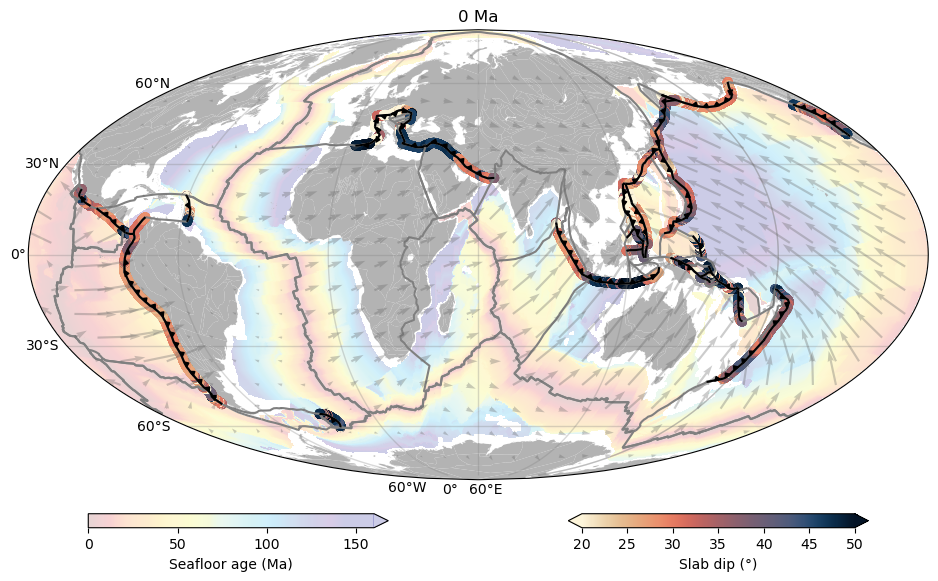

In [23]:
plot_slabdip(0)

In [24]:
# Use LokyBackend to protect the netCDF routine
slabdip_img = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_slabdip) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 70.0min finished


In [25]:
import moviepy.editor as mpy

frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/slab_dip/slab_dip_{}.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/slab_dip.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//slab_dip.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//slab_dip.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//slab_dip.mp4


## Plots of subduction convergence rate and MOR spreading rate

In [26]:
from cmaptools import readcpt, joincmap, DynamicColormap
cptfile = "../utils/age_1000-0.cpt"
custom_cmap = readcpt(cptfile)
conv_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('conv_cmap', ['white', 'mediumturquoise', 'teal', 'darkslategray', '#011C1A'])
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('conv_cmap', ['white', 'wheat', 'darkgoldenrod', '#7D4B20', '#1F1300'])


def plot_spread_conv(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    
    if time == 1000:
        original_time = time
        time = 999
        ax.set_title("{} Ma".format(original_time))
        save_time = original_time
    else:
        ax.set_title("{} Ma".format(time))
        save_time = time

    extent_globe = [-180,180,-90,90]

    # ---------- PLOT THE AGE GRID
    age_grid, _ = defineGridFiles()
    agegrid = gplately.Raster(age_grid.format(time))

    cmap = custom_cmap
    cmap.set_bad('k',1.)

    im = ax.imshow(agegrid.data, extent=extent_globe, cmap=cmap, origin='lower', alpha=0.2,

               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
    )

    # ---------- PLOT COASTLINES, TOPOLOGIES ETC
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.5, zorder=10, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.9', edgecolor='none',)
    gplot.plot_trenches(ax, zorder=9)
    gplot.plot_subduction_teeth(ax, zorder=9)

    
    # ---------- COLLECT TRENCH DATA FROM H2O NOTEBOOK OUTPUTS
    subduction_filename = "../H2O_review_paper/H2O_Review_Bundle/{}/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(folder_name, int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_convergence = np.clip(df_time['vel'].to_numpy(), 0, 1e99)*1e2 # Start in m, convert to cm

    # ---------- CALCULATE RIDGE DATA IN-SITU
    ridge_data = model.tessellate_mid_ocean_ridges(
        time,
        tessellation_threshold_radians=np.radians(0.01),
        anchor_plate_id=0)
    
    curr_mor_lon = ridge_data[:,0]
    curr_mor_lat = ridge_data[:,1]
    curr_mor_divergence = ridge_data[:,2] # already in cm/yr

    ax.set_global()
    
    # ---------- PLOT SCATTERPLOTS OF VELOCITIES USING CUSTOM COLORMAPS

    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=curr_subd_convergence, cmap=conv_cmap, vmin=0, vmax=14,
        transform=ccrs.PlateCarree(), rasterized=True, 
    )
    sc2 = ax.scatter(curr_mor_lon, curr_mor_lat, c=curr_mor_divergence, cmap=div_cmap, vmin=0, vmax=14,
        transform=ccrs.PlateCarree(), rasterized=True, 
    )
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax1 = fig.add_axes([0.0, 0.21, 0.25, 0.02])
    cb1 = fig.colorbar(sc,  cax=cax1, ticks=np.arange(0,12.51,2.5), orientation='horizontal', label='Subduction convergence rate (cm/yr)', extend='max')

    cax2 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb2 = fig.colorbar(sc2,  cax=cax2, orientation='horizontal', label='Mid-ocean ridge spreading rate (cm/yr)', extend='max')

    cax3 = fig.add_axes([0.6, 0.21, 0.25, 0.02])
    cb2 = fig.colorbar(im,  cax=cax3, orientation='horizontal', label='Seaflor age (Myr)', extend='max')

    cb1.set_ticklabels(np.arange(0,12.51,2.5))
    #cb2.set_ticklabels(np.arange(0,12.51,2.5))
    
    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/Videos/subd_convergence", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/Videos/subd_convergence/subd_convergence_{}Ma.{}".format(save_time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()
        
    plt.close()
    return

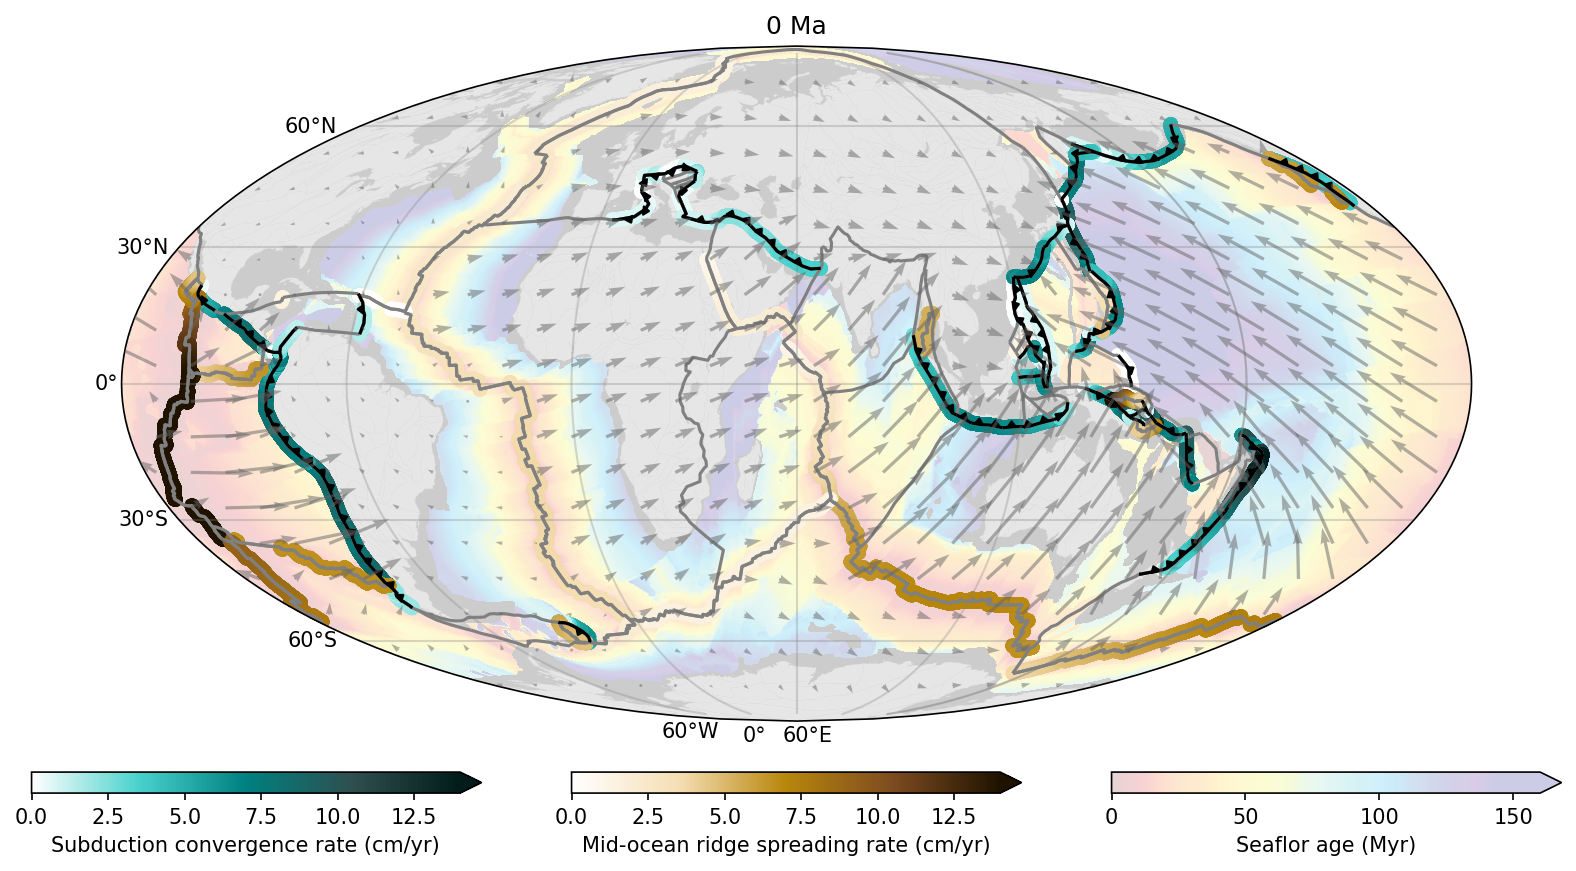

In [27]:
plot_spread_conv(0)

In [28]:
# Use LokyBackend to protect the netCDF routine
spreading_convergence = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_spread_conv) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 108.3min finished


In [30]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/Videos/subd_convergence/subd_convergence_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/Videos/subd_convergence.mp4",
    codec='mpeg4', 
    ffmpeg_params=['-preset', 'veryslow', '-crf', '17'] 
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//Videos/subd_convergence.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//Videos/subd_convergence.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//Videos/subd_convergence.mp4


## Plots of seafloor spreading rate

In [31]:
def plot_sfs(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]
    _, sr_grid = defineGridFiles()
    srgrid = gplately.Raster(sr_grid.format(time))

    im = ax.imshow(srgrid.data, extent=extent_globe, cmap='YlGnBu_r', origin='lower',

               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
    )
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none')
    gplot.plot_trenches(ax, color='w', linewidth=7, zorder=4)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, )
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)

    # fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max', shrink=0.4)
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor spreading rate (mm/yr)', shrink=0.8, pad=0.1, extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/seafloor_spreading_rate", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/seafloor_spreading_rate/seafloor_spreading_rate_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
    plt.close()
    return


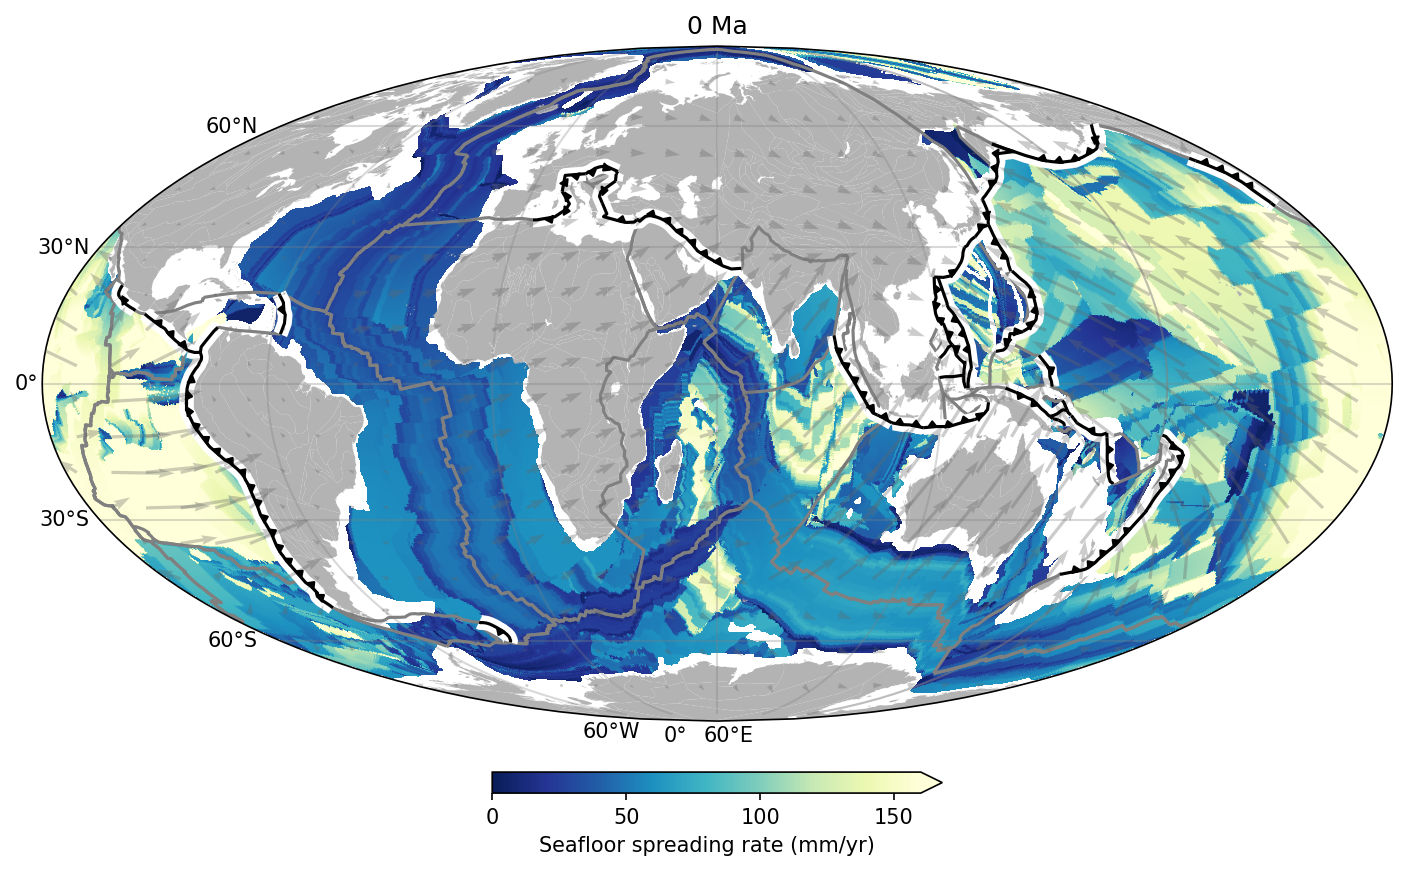

In [32]:
plot_sfs(time=0)

In [33]:
# Use LokyBackend to protect the netCDF routine
sfs = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sfs) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 83.6min finished


In [34]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/seafloor_spreading_rate/seafloor_spreading_rate_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/seafloor_spreading_rate.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//seafloor_spreading_rate.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//seafloor_spreading_rate.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//seafloor_spreading_rate.mp4


## Plots of organic sedimentary carbon

In [6]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_organic_sed(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(

        "../Outputs/{}/Notebook01/Reservoirs/Organic_Sediments/mean/carbon_organic_sediments_grid_{:04d}.nc".format(folder_name, time)
    ).data

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.batlow, vmin=0, vmax=5,
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='lightgrey',  )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    if save_fig:
        os.makedirs(output_directory+"/organic_sediments", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/organic_sediments/organic_sediments_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

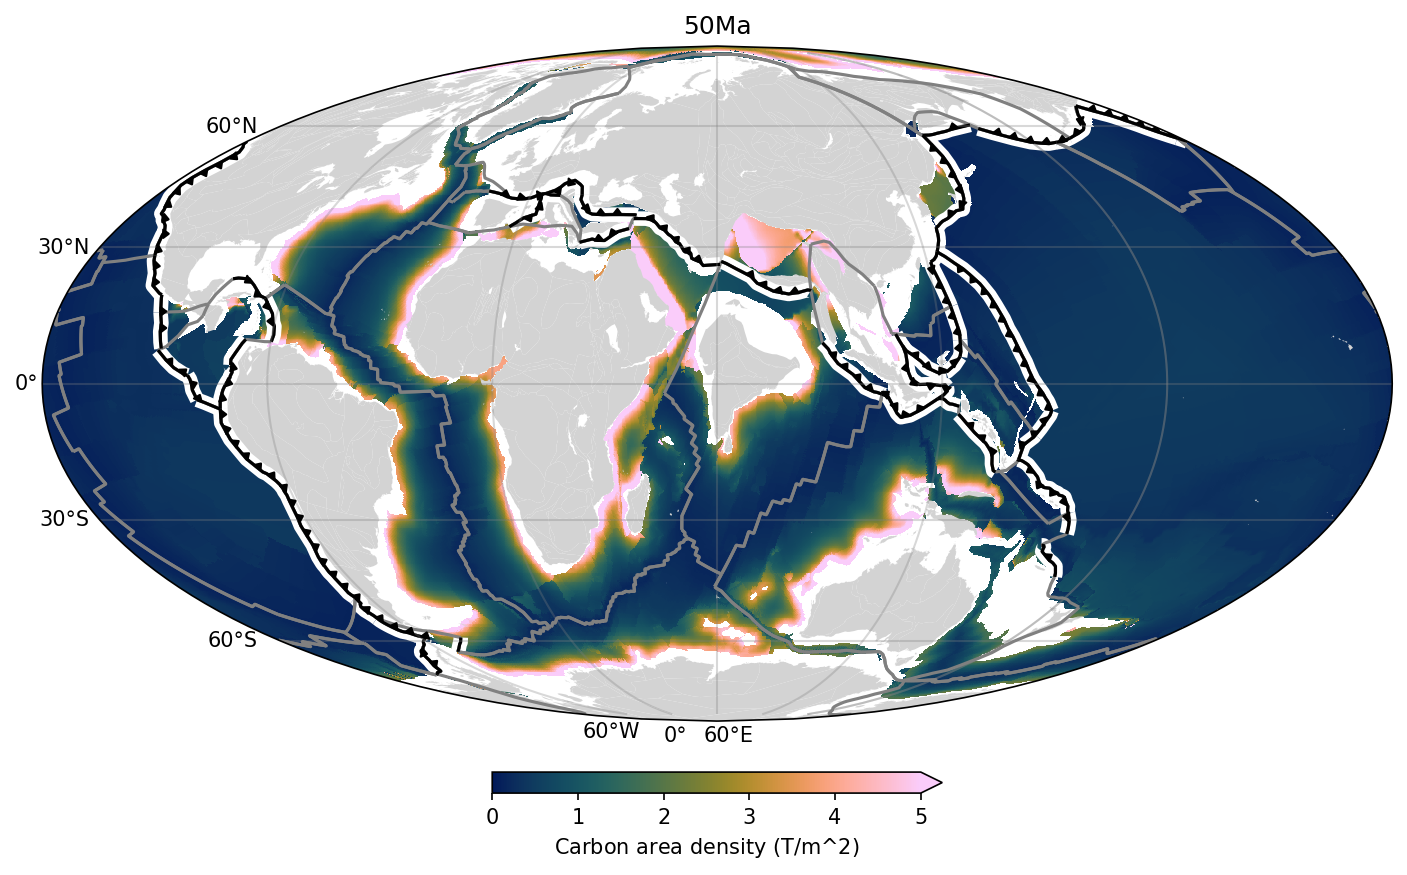

In [7]:
plot_organic_sed(time=50)

In [8]:
# Use LokyBackend to protect the netCDF routine
organic_seds = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_organic_sed) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 22.6min finished


In [9]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/organic_sediments/organic_sediments_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/organic_sediments_carbon_mean_area_density.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//organic_sediments_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//organic_sediments_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//organic_sediments_carbon_mean_area_density.mp4


## Plots of total sediment thickness

In [10]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def plot_total_sed(time, save_fig=False):

    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(
        grid_directory+"TotalSediment/Muller2022_sed_thick_0.1d_{:.1f}Ma.nc".format(time)
    ).data

    lognorm_cmap = matplotlib.cm.viridis
    lognorm_cmap.set_bad((1,1,1), alpha=0)

    # time by 1e6 to go from Mt to t
    im = ax.imshow(
        grd, origin='lower', cmap=lognorm_cmap,
        norm=mcolors.LogNorm(vmin=1e1, vmax=1e3),
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='lightgrey',  )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Thickness (m)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    if save_fig:
        os.makedirs(output_directory+"/total_sediment", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/total_sediment/total_sediment_thickness_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

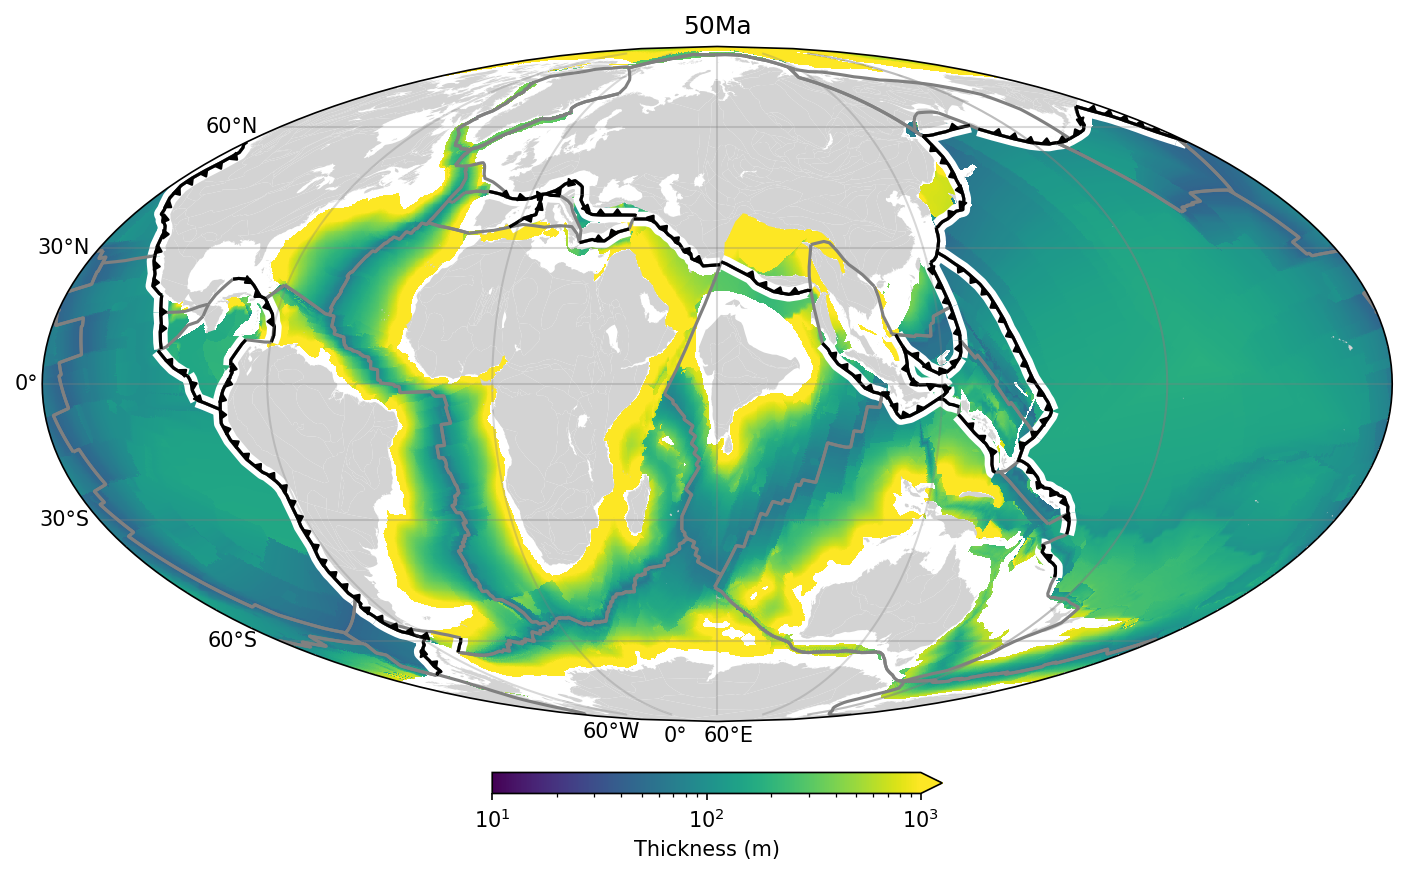

In [11]:
plot_total_sed(time=50)

In [12]:
# Use LokyBackend to protect the netCDF routine
total_sed = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_total_sed) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 38.1min finished


In [13]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/total_sediment/total_sediment_thickness_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/total_sediment_thicknes.mp4",
    codec='mpeg4',
    bitrate='20000'
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//total_sediment_thicknes.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//total_sediment_thicknes.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//total_sediment_thicknes.mp4


### Sediment accretion and erosion

In [43]:
def plot_sed_accreted(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    
    if time == 1000:
        original_time = time
        time = 999
        ax.set_title("{} Ma".format(original_time))
        save_time = original_time
    else:
        ax.set_title("{} Ma".format(time))
        save_time = time

    extent_globe = [-180,180,-90,90]

    # ---------- PLOT COASTLINES, TOPOLOGIES ETC
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.5, zorder=10, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.9', edgecolor='none')

    
    # ---------- COLLECT TRENCH DATA FROM H2O NOTEBOOK OUTPUTS
    subduction_filename = "../H2O_review_paper/H2O_Review_Bundle/{}/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(folder_name, int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_convergence = np.clip(df_time['vel'].to_numpy(), 0, 1e99) # Start in m

    # Calculate sediment accretion at the current timestep
    accretion = (-0.4/0.068)*curr_subd_convergence + 0.4
    accretion_clipped = np.clip((-0.4/0.068)*curr_subd_convergence + 0.4, 0.0, 1e99)
    
    # Erosion
    erosion = 1 - accretion
    erosion_clipped = 1 - accretion_clipped
    
    accretion_pm40 = np.clip(accretion*100, -40., 40.),
    
    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=accretion_pm40, cmap='BrBG', vmin=-40, vmax=40,
                 transform=ccrs.PlateCarree(), rasterized=True,)
    
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, color='k')
    gplot.plot_subduction_teeth(ax, zorder=9)     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(sc,  cax=cax1, orientation='horizontal', label='% Sediment accreted', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    
    if save_fig:
        os.makedirs(output_directory+"/accretion", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/accretion/sed_accretion_to_erosion_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

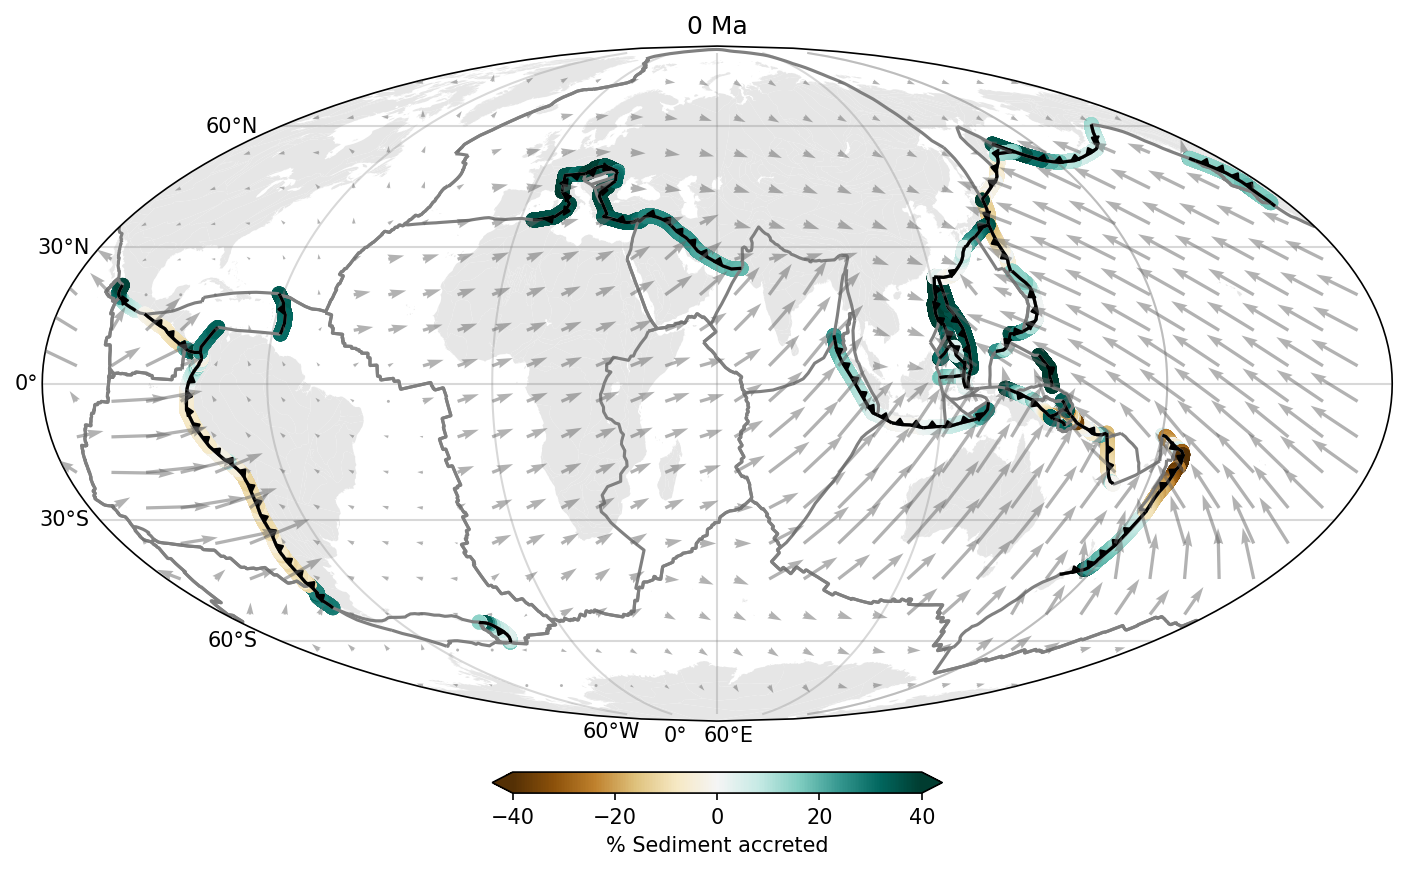

In [44]:
plot_sed_accreted(0)

In [45]:
# Use LokyBackend to protect the netCDF routine
carb_sed_times = np.arange(170,-1,-1)

accretion_erosion = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sed_accreted) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in carb_sed_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  5.7min finished


In [46]:
frame_list = []
for time in carb_sed_times:
    frame_list.append(
        output_directory+"/accretion/sed_accretion_to_erosion_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/sed_accretion_to_erosion.mp4", fps=24, 
    codec='mpeg4', 
    ffmpeg_params=['-preset', 'veryslow', '-crf', '17'] )

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//sed_accretion_to_erosion.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//sed_accretion_to_erosion.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//sed_accretion_to_erosion.mp4


### Plots of subduction convergence at continental arcs

In [8]:
# For now, let's use the continent contours as the `gplot` continents
contoured_continents = '../Muller2022_InputGrids/ContinentalMasksNoArcs/continent_contour_features.gpmlz'

max_time = 1000
time = max_time
gplot = gplately.PlotTopologies(model, time=time, coastlines=coastlines, continents=contoured_continents)


In [9]:

# updated carbonate platforms file
platforms_filename = "./ActiveCarbonatePlatforms_Neoproterozoic-to-Present.gpml"

# ensure all features have an active time of 0
carb_platform_fc = pygplates.FeatureCollection(platforms_filename)

In [10]:
from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds


def get_continent_polygon_coordinates(continent_polygons=None, grid=None, resX=0.2, resY=0.2):
    """
    Grids continents, and extracts coordinates
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    if grid:
        platforms_grid = gplately.Raster(grid,
            resample=(resY, resX),
        ).data
        xq, yq = np.meshgrid(np.arange(-180,180+resX,resX),
                             np.arange(-90, 90+resY, resY))
        
    elif continent_polygons:
        platforms_grid = rasterize(gplately.geometry.pygplates_to_shapely(continent_polygons),
                                   out_shape=(ny,nx),
                                   transform=from_bounds(-180, 90, 180, -90, nx, ny))

        xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                             np.linspace(-90, 90, ny))

    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords


# Get present-day subduction zone coordinates
time = 0
d_tols = [350]

def get_continental_arc_speeds(time):
    
    # reconstruct continents
    gplot.time = time
    
    agegrid_filename, spreadrate_filename = defineGridFiles()
    tessellation_threshold_radians = np.radians(0.01)

    # Get continets 
    clons, clats = get_continent_polygon_coordinates(grid=grid_directory+"/ContinentalMasksNoArcs/continent_mask_{}.0.nc".format(time))
    
    ###################### Subduction convergence data ########################
    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)

    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)

    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length # m
    subd_len_sum = np.sum(subduction_length) 

    subduction_convergence = subduction_df.vel * 100 # m/yr to cm/yr
    subd_vel_mean, subd_vel_std = np.mean(subduction_convergence), np.std(subduction_convergence)

    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_convergence * subduction_length) # m^2/yr

    
    ################## K-D TREE 1: Find trenches intersecting continent polygons ############

    trench_xyz   = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat, degrees=True)
    continent_xyz = gplately.tools.lonlat2xyz(clons, clats, degrees=True)
    tree = cKDTree(np.c_[continent_xyz])
    distance_to_trench, index = tree.query(np.c_[trench_xyz])
    distance_to_trench *= 6371
    
    length_per_dtol = np.zeros((len(d_tols), 1))
    
    for i, d_tol in enumerate(d_tols):
        mask_dist = distance_to_trench <= d_tol

        in_continent_trench_lons = subduction_lon[mask_dist]
        in_continent_trench_lats = subduction_lat[mask_dist]
        in_continent_trench_vel = subduction_convergence[mask_dist]
        
    if time > 500:
        return in_continent_trench_lons, in_continent_trench_lats, in_continent_trench_vel, clons, clats, None, None
        
    else:
        ################## K-D TREE 2: Find continent arcs intersecting carbonate platforms ############
        cont_arc_xyz = gplately.tools.lonlat2xyz(in_continent_trench_lons, in_continent_trench_lats, degrees=True)

        # Reconstruct carbonate platforms at this time 
        reconstructed_platforms = model.reconstruct(platforms_filename, time)
        cp_lons, cp_lats = get_continent_polygon_coordinates(continent_polygons=reconstructed_platforms)
        carb_plat_xyz = gplately.tools.lonlat2xyz(cp_lons, cp_lats, degrees=True)

        carb_plat_tree = cKDTree(np.c_[carb_plat_xyz])
        distance_to_cont_arc, index = carb_plat_tree.query(np.c_[cont_arc_xyz])
        distance_to_cont_arc *= 6371

        for i, d_tol in enumerate(d_tols):
            mask_dist = distance_to_cont_arc <= d_tol

            carb_plat_intersecting_lons = in_continent_trench_lons[mask_dist]
            carb_plat_intersecting_lats = in_continent_trench_lats[mask_dist]
            carb_plat_intersecting_vel = in_continent_trench_vel[mask_dist]


        return carb_plat_intersecting_lons, carb_plat_intersecting_lats, carb_plat_intersecting_vel, clons, clats, cp_lons, cp_lats

In [13]:
def plot_trench_on_continental_arcs(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]

    gplot.time = time

    
    
    if time > 500:
        lons, lats, speeds, clon, clat, _,_ = get_continental_arc_speeds(time)
    else:
        lons, lats, speeds, clon, clat, cplon, cplat = get_continental_arc_speeds(time)
        
    
    im = ax.scatter(clon, clat, transform=ccrs.PlateCarree(), color='gainsboro', s=5)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none')
    
    if time < 501:
        cp = ax.scatter(cplon, cplat, transform=ccrs.PlateCarree(), color='#ABCDEF', alpha=0.1, s=0.5)
        
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7)
    
    im = ax.scatter(lons, lats, transform=ccrs.PlateCarree(), c=speeds, vmax=10, vmin=0, s=40, cmap='plasma')
    gplot.plot_trenches(ax, color='w', linewidth=4)

    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, )
    gplot.plot_subduction_teeth(ax, zorder=9)

    latlonticks(ax)

    # fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max', shrink=0.4)
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cax1, orientation='horizontal', label='Convergence rate (cm/yr)', shrink=0.8, pad=0.1, extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)
    
    ax.set_global()
    
    if save_fig:
        os.makedirs(output_directory+"/continental_arcs", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/continental_arcs/continental_arc_convergence{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

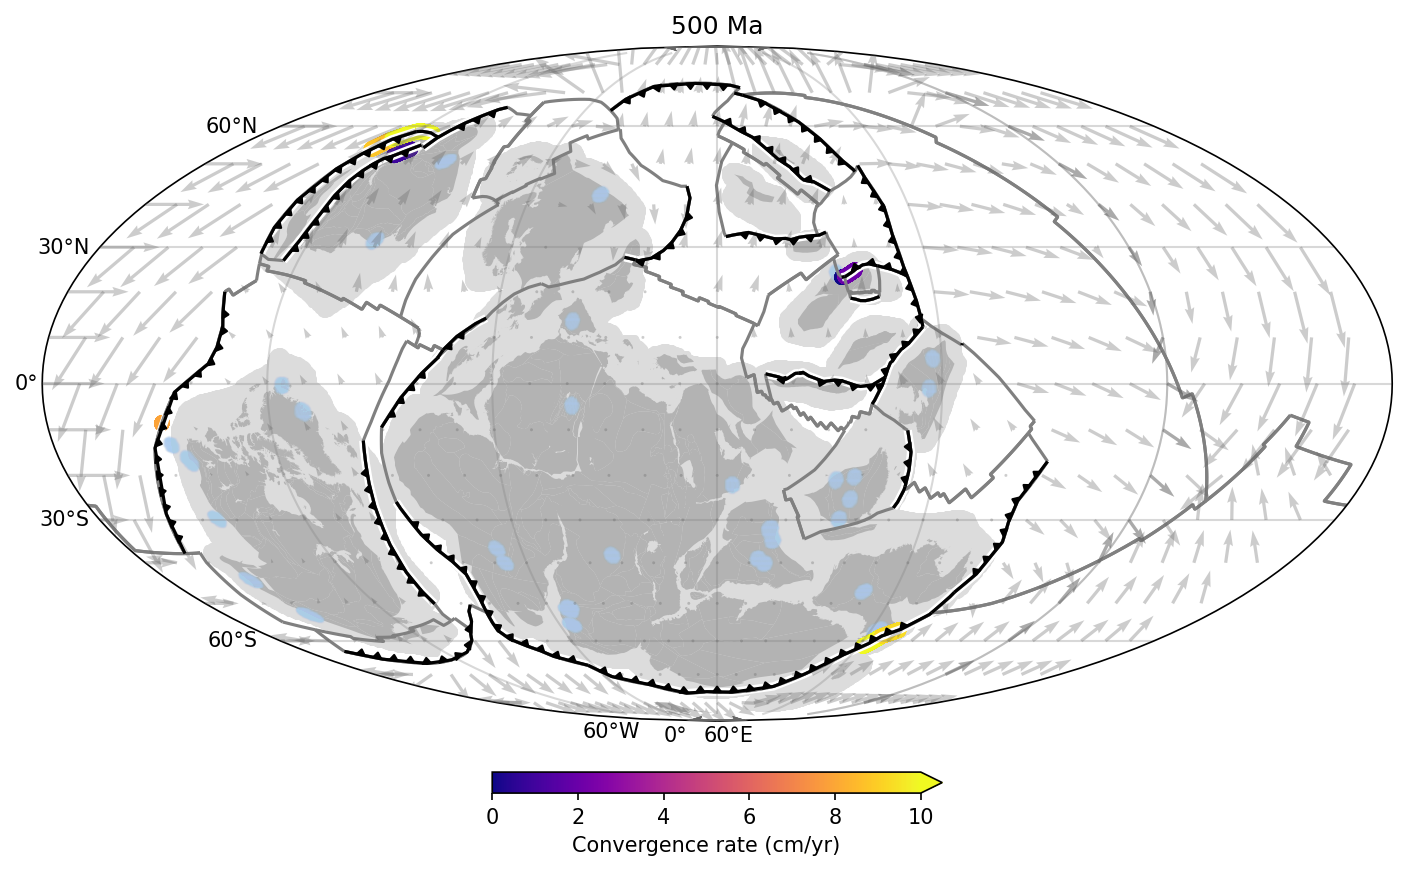

In [14]:
plot_trench_on_continental_arcs(500)

In [15]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
"""       
# Use LokyBackend to protect the netCDF routine
cont_arc = Parallel(n_jobs=-1, backend='threading', verbose=1) \
(delayed(plot_trench_on_continental_arcs) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in np.arange(1000,346,-1))
"""
for time in np.arange(500, 420, -1):
    plot_trench_on_continental_arcs(time, save_fig=True)

env: PYTHONWARNINGS=ignore::RuntimeWarning


In [16]:
frame_list = []
for time in np.arange(500,-1,-1):
    frame_list.append(
        output_directory+"/continental_arcs/continental_arc_convergence{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/continental_arc_convergence.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Apr21/Videos//continental_arc_convergence.mp4.
Moviepy - Writing video ../Outputs/Muller22_Apr21/Videos//continental_arc_convergence.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Apr21/Videos//continental_arc_convergence.mp4
